# Idealised Galaxy Disk Simulations

Here we will use the [DICE](https://bitbucket.org/vperret/dice/src/master/) initial conditions generator to create galaxy disk initial conditions (ICs).

Begin by going to the [DICE](https://bitbucket.org/vperret/dice/src/master/) website and follow the instructions there to download and install the code. You can then run DICE with the dwarf galaxy configuration files found in the ICs/dwarf_galaxy sub-subfolder (under the tutorial directory, i.e. the directory you're in right now). This generates ICs that RAMSES can read to run a simulation of an isolated galaxy. It is easiest if you generate the ICs into that same sub-subfolder, so you don't have to change anything in the RAMSES namelist (which needs to know where the ICs are stored).

Below we will run and analyze a RAMSES simulation with this fiducial dwarf galaxy. But later you can play with the DICE parameter files (.config and .params) for generating your own galaxy ICs with different properties (e.g. halo and stellar mass, gas to stellar mass fraction, disc thickness etc.).

## Running RAMSES with DICE ICs

For running with the DICE ICs, RAMSES needs to be compiled with the DICE patch. For this, go to the RAMSES source code and create a new binary directory e.g. ramses/bin_dice. Use the normal 3d Makefile as a starting point but add to it <br>
**PATCH = ../patch/init/dice** <br>
Then compile the code (make sure NDIM=3 and MPI=1 in the Makefile). After the code has compiled, you can go to the sub-directory named *dwarf_galaxy_run* and run RAMSES with the run_parallel binary (in which you may need to change the path to RAMSES).

We are now running a $~10^{11} \ M_{\odot}$ halo with $~50$ pc resolution, star formation and SN feedback (but no radiation), so this run takes some time to get to the end goal of $250 \ {\rm Myr}$ of galaxy disk evolution. Still, you will pretty quickly start to get outputs, and then you can execute the notebook cells below to do some visualisation.

You can then play with increasing the resolution, using more sophisticated models for star formation or feedback in your namelist file. See the RAMSES wiki -> user's guide on Github for descriptions of the available parameters. You can also generate different galaxy disk ICs with DICE. Start from the configuration files coming with this tutorial and refer to the DICE documentation for an overview of the parameters and what they do.

## Visualizing the outputs with Yt

In [1]:
# Import the relevant modules for reading RAMSES outputs and visualising them
import yt
import numpy as np
from matplotlib import pyplot as plt
yt.set_log_level(0)

In [3]:
# Load RAMSES snapshot with Yt
snap=14 # Snapshot number to look at
snapstr = "%05d" % snap
path='./dwarf_galaxy_run/'
ds = yt.load(path+'output_'+snapstr+'/info_'+snapstr+'.txt')
time_yr = ds.current_time.in_units('yr')

In [36]:
# Show the available variables
#sorted(ds.field_info)

The total gas mass is  1077542029.64644 Msun



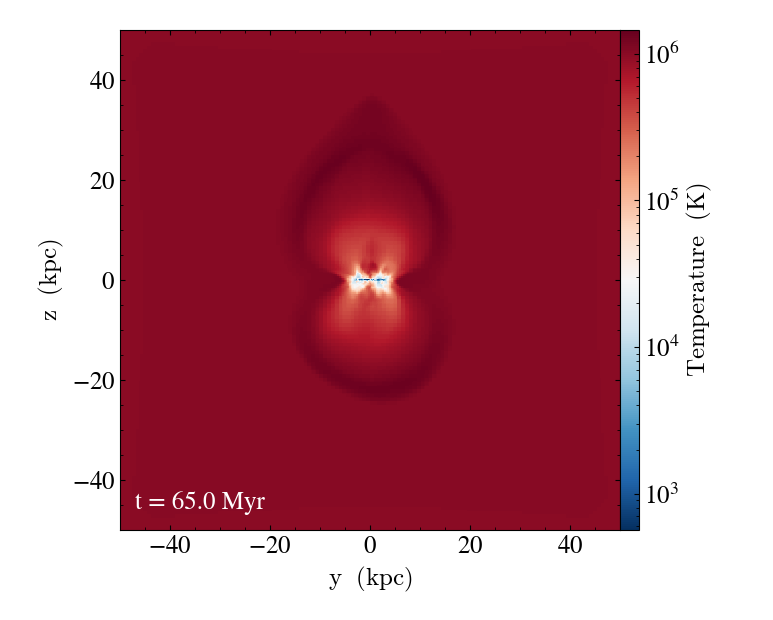


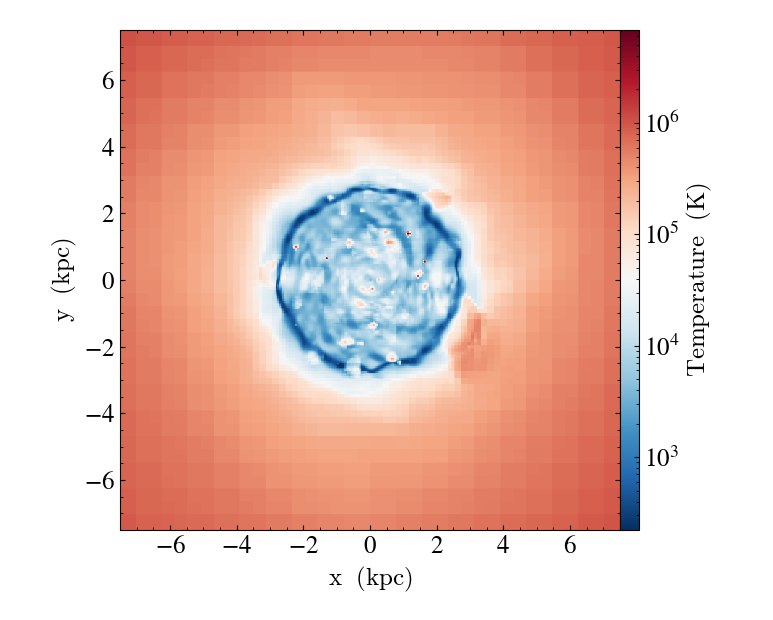


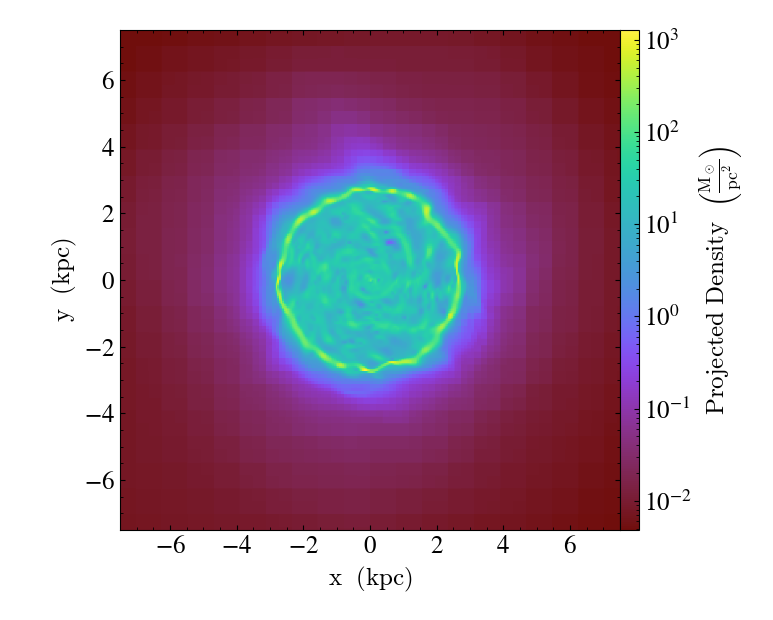


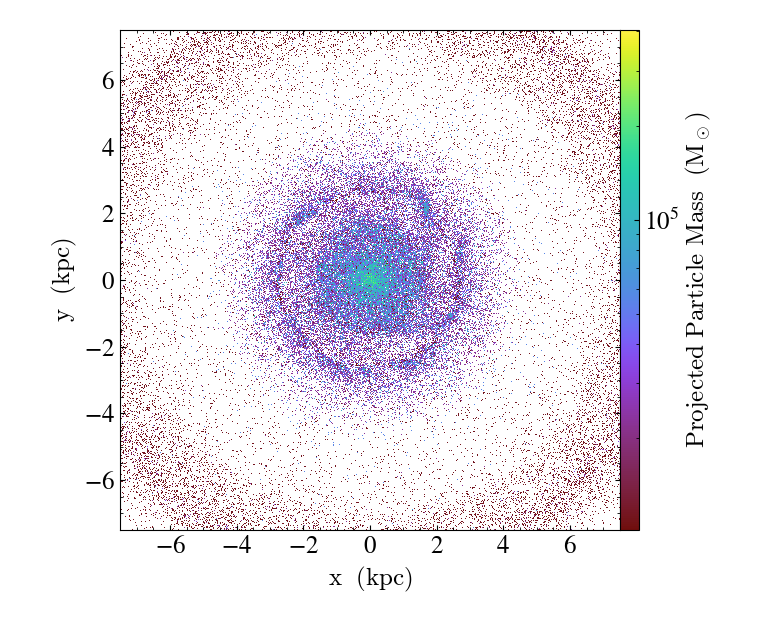

In [5]:
# Show projection maps
ad=ds.all_data()
m_tot = np.sum(ad['density']*ad['dx']**3)
print("The total gas mass is ",m_tot.in_units('Msun'))
time_Myr = ds.current_time.in_units('Myr')

# projection of the full box in temperature, face-on
p = yt.ProjectionPlot(ds, 'x', 'temperature',weight_field='density')
p.annotate_timestamp()
p.set_cmap(('temperature'), "RdBu_r")
p.set_figure_size(5)
p.show()

# zoomed-in projection of temperature, density, and stars
p = yt.ProjectionPlot(ds, 'z', 'temperature',weight_field='density',width=(15,'kpc'))
p.set_cmap(('temperature'), "RdBu_r")
p.set_figure_size(5)
p.show()

p = yt.ProjectionPlot(ds,'z', 'density',width=(15,'kpc'))
p.set_unit('density', 'Msun/pc**2')
p.set_figure_size(5)
p.show()

p = yt.ParticlePlot(ds, ('star', 'particle_position_x'), ('star', 'particle_position_y'),
                    ('star','particle_mass'),width=(15,'kpc'))
p.set_unit(('star', 'particle_mass'), 'Msun')
p.set_figure_size(5)
p.show()

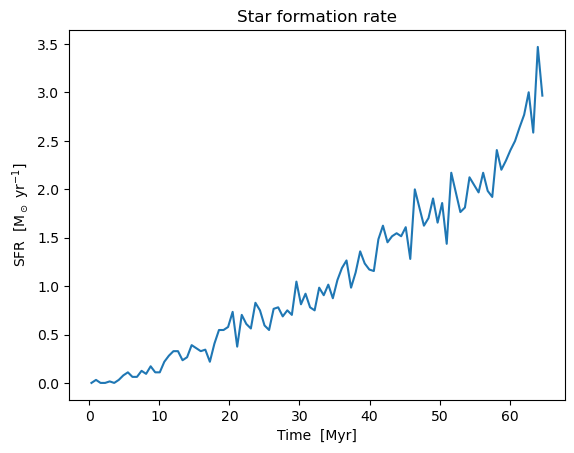

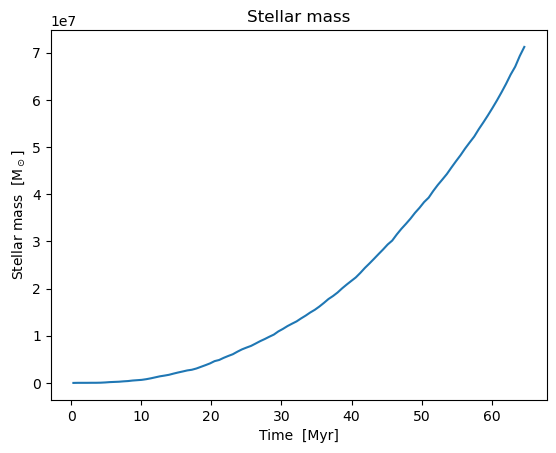

In [6]:
# Plot star formation history
ad = ds.all_data()
masses = ad['star', 'particle_mass'].in_units('Msun')
formation_time = ad['star', 'particle_birth_time'].in_units('yr')
time_range = [-100, time_yr.v] # years
n_bins = 100
hist, bins = np.histogram(formation_time, bins=n_bins, range=time_range,)
inds = np.digitize(formation_time, bins=bins)
time = (bins[:-1] + bins[1:])/2
sfr = np.array([masses[inds == j+1].sum()/(bins[j+1]-bins[j])
                for j in range(len(time))])
mass = np.array([masses[inds == j+1].sum()
                for j in range(len(time))])
mass= np.cumsum(mass)
#sfr[sfr == 0] = np.nan
# SFR plot
plt.plot(time/1e6, sfr)
plt.title('Star formation rate')
plt.xlabel('Time  [Myr]')
plt.ylabel('SFR  [M$_\odot$ yr$^{-1}$]')
plt.show()

# Plot of stellar mass formed
fig=plt.figure()
plt.plot(time/1e6, mass)
plt.title('Stellar mass')
plt.xlabel('Time  [Myr]')
plt.ylabel('Stellar mass  [M$_\odot$]')
plt.show()

## Making movies

The RAMSES simulation namelist contains MOVIE_PARAMS, which tell the code to generate binary files with short time intervals showing  face-on and edge-on projections of gas density, temperature, and stars.

The first cell below reads those binary files and creates .png images out of them, each with the density, temperature, and stars superimposed.

The second cell then calls ffmpeg to squeeze all those pngs into one .mp4 movie file. For that second cell to work, you need to have ffmpeg installed.

In [9]:
# Read binary movie frames and make .png images
import os
import glob
import numpy as np
from scipy.io import FortranFile
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

mov_proj = 1 # Movie projection (1=face-on, 2=edge-on)     ####################CHANGE THIS FOR DIFFERENT PROJECTION

plt.ioff() # So as not to show plots
#plt.ion() # So as to show plots
fig = plt.figure(frameon=False)
nx = 500
ny = 500
nypic=ny  #int(ny*0.6)
plt.subplots_adjust(left=0., bottom=0.,
                    right=1.+1.0/nx, top=1.+1.0/nypic,
                    wspace=0., hspace=0.)
fig.set_size_inches(nx/100.*.7,nypic/100.*.7)
quants = {
    "temp": {
        "name": "temp",
        "data": np.array([]),
        "min": 1e10,
        "max": -1e10,
    },
    "dens": {
        "name": "dens",
        "data": np.array([]),
        "min": 1e10,
        "max": -1e10,
    },
    "stars": {
        "name": "stars",
        "data": np.array([]),
        "min": 1e10,
        "max": -1e10,
    },
}
d_cmap=matplotlib.cm.viridis

cmap = matplotlib.cm.bone
stars_cmap = cmap(np.arange(cmap.N))
stars_cmap[:,-1] = np.linspace(0, 1, cmap.N)
stars_cmap = ListedColormap(stars_cmap)

cmap = matplotlib.cm.RdBu_r
temp_cmap = cmap(np.arange(cmap.N))
temp_cmap[:,-1] = np.linspace(0, 1, cmap.N)
temp_cmap = ListedColormap(temp_cmap)

movie_path = '%s/movie%d/'%(path,mov_proj)
png_dir = '%s/pngs'%(path)
try:
    os.mkdir(png_dir) # Create directory to store movie frames in png files
except FileExistsError:
    do_nothing=True
all_ok = True

# Figure out the number of frames for the movie
searchstring = '%s/info_'%(movie_path)
frames = glob.glob(searchstring+'*') # Frame strings
i_frames = [ int(str[len(searchstring):len(searchstring)+4]) for str in frames ]
i_frames = sorted(i_frames)         # Sort them
imin = i_frames[0]
imax = i_frames[len(i_frames)-1]

# Loop over the movie frames and generate .png images
for i in range(imin,imax+1):
    # Read the info file:
    info = open(f"{movie_path}info_{str(i).zfill(5)}.txt").readlines()
    time_sec=0.0
    time_sec = float(info[8].split("=")[-1].strip())
    unit_l =   float(info[15].split("=")[-1].strip())
    unit_d =   float(info[16].split("=")[-1].strip())
    unit_t =   float(info[17].split("=")[-1].strip())
    time_myr = time_sec*unit_t/3.156e13
    
    # Load in the data
    for q in quants:
        fname = f"{quants[q]['name']}_{str(i).zfill(5)}.map"
        ffile = FortranFile(f"{movie_path}{fname}")
        [time, fdw, fdh, fdd] = ffile.read_reals('d')
        [frame_nx, frame_ny] = ffile.read_ints()
        data = np.array(ffile.read_reals('f4'), dtype=np.float64)
        try: 
            quants[q]["data"] = data.reshape(frame_nx,frame_ny)
            quants[q]["min"] = quants[q]["data"][quants[q]["data"] > 0].min()
            quants[q]["max"] = quants[q]["data"][quants[q]["data"] > 0].max()
            quants[q]["data"][quants[q]["data"] < quants[q]["min"]] = 1e-5 * quants[q]["min"]
        except ValueError:
            all_ok = False
        f, axs = plt.subplots(1,1,figsize=(7.5,7.5),sharex=True,sharey=True)
    plt.subplots_adjust(left=0, right=1.0, top=1.0, bottom=0)
    axs.imshow(np.log10(quants["dens"]["data"]),vmin=-6,vmax=2,cmap=d_cmap,aspect='auto',interpolation='none')
    axs.imshow(np.log10(quants["temp"]["data"]),vmin=4.5,vmax=6.5,cmap=temp_cmap)
    axs.imshow(np.log10(quants["stars"]["data"]),vmin=-5,vmax=-2,cmap=stars_cmap,alpha=0.5)
    plt.axis("off")
    # Text showing simulation time
    axs.text(0.97, 0.03,'%.2f Myr'%(time_myr), fontsize=15,transform=axs.transAxes
             , verticalalignment='bottom', horizontalalignment='right', color='white')
    # Bar showing length scale
    frame_width_kpc = fdw*unit_l/3.08e21
    rect = mpatches.Rectangle((0.055,0.03),10./frame_width_kpc,0.002,color='white',transform=axs.transAxes)
    axs.add_patch(rect)
    axs.text(0.055, 0.01+15./frame_ny, ('%d kpc'%(10)),
            verticalalignment='bottom', horizontalalignment='left',
            transform=axs.transAxes, color='white', fontsize=15. )
   
    # Store frame in png file
    filename = '%s/frame_%d_%05d.png'%(png_dir,mov_proj,i)
    print(filename)
    f.savefig(filename, dpi=100)

./dwarf_galaxy_run//pngs/frame_1_00001.png
./dwarf_galaxy_run//pngs/frame_1_00002.png
./dwarf_galaxy_run//pngs/frame_1_00003.png
./dwarf_galaxy_run//pngs/frame_1_00004.png
./dwarf_galaxy_run//pngs/frame_1_00005.png
./dwarf_galaxy_run//pngs/frame_1_00006.png
./dwarf_galaxy_run//pngs/frame_1_00007.png
./dwarf_galaxy_run//pngs/frame_1_00008.png
./dwarf_galaxy_run//pngs/frame_1_00009.png
./dwarf_galaxy_run//pngs/frame_1_00010.png
./dwarf_galaxy_run//pngs/frame_1_00011.png
./dwarf_galaxy_run//pngs/frame_1_00012.png
./dwarf_galaxy_run//pngs/frame_1_00013.png
./dwarf_galaxy_run//pngs/frame_1_00014.png
./dwarf_galaxy_run//pngs/frame_1_00015.png
./dwarf_galaxy_run//pngs/frame_1_00016.png
./dwarf_galaxy_run//pngs/frame_1_00017.png
./dwarf_galaxy_run//pngs/frame_1_00018.png
./dwarf_galaxy_run//pngs/frame_1_00019.png
./dwarf_galaxy_run//pngs/frame_1_00020.png
./dwarf_galaxy_run//pngs/frame_1_00021.png
./dwarf_galaxy_run//pngs/frame_1_00022.png
./dwarf_galaxy_run//pngs/frame_1_00023.png
./dwarf_gal

In [11]:
# Run ffmpeg to make a .mp4 out of the .png frames
import subprocess
movie_filename = '%smovie%d.mp4'%(path,mov_proj)
frames = '%spngs/frame_%d_%%*.png'%(path,mov_proj)
fps=50.
speed=60.
quality=23
print("Calling ffmpeg! Output: {mov}".format(mov=movie_filename))
print("{binffmpeg} -i {input}\
                     -y -vcodec h264 -pix_fmt yuv420p\
                     -r {fps} -filter:v 'setpts={speed}*PTS'\
                     -crf {quality} {output}".
                    format(binffmpeg='ffmpeg', input=frames,
                           fps=fps, speed=speed/fps,
                           quality=quality, output=movie_filename))
subprocess.call("{binffmpeg} -i {input}\
                     -y -vcodec h264 -pix_fmt yuv420p\
                     -r {fps} -filter:v 'setpts={speed}*PTS'\
                     -crf {quality} {output}".
                    format(binffmpeg='ffmpeg', input=frames,
                           fps=fps, speed=60./fps,
                           quality=quality, output=movie_filename), shell=True)
print('####################################################################')
print('-----------Your new movie is here: ', movie_filename)
print('####################################################################')


Calling ffmpeg! Output: ./dwarf_galaxy_run/movie1.mp4
ffmpeg -i ./dwarf_galaxy_run/pngs/frame_1_%*.png                     -y -vcodec h264 -pix_fmt yuv420p                     -r 50.0 -filter:v 'setpts=1.2*PTS'                     -crf 23 ./dwarf_galaxy_run/movie1.mp4


ffmpeg version N-85453-g27ebdcf Copyright (c) 2000-2017 the FFmpeg developers
  built with gcc 4.4.7 (GCC) 20120313 (Red Hat 4.4.7-4)
  configuration: --prefix=/home/cral/rosdahl/ffmpeg_build --extra-cflags=-I/home/cral/rosdahl/ffmpeg_build/include --extra-ldflags='-L/home/cral/rosdahl/ffmpeg_build/lib -ldl' --bindir=/home/cral/rosdahl/bin --pkg-config-flags=--static --enable-gpl --enable-libx264
  libavutil      55. 60.101 / 55. 60.101
  libavcodec     57. 92.100 / 57. 92.100
  libavformat    57. 72.100 / 57. 72.100
  libavdevice    57.  7.100 / 57.  7.100
  libavfilter     6. 84.101 /  6. 84.101
  libswscale      4.  7.100 /  4.  7.100
  libswresample   2.  8.100 /  2.  8.100
  libpostproc    54.  6.100 / 54.  6.100
[image2 @ 0x2dae7a0] Pattern type 'glob_sequence' is deprecated: use pattern_type 'glob' instead
Input #0, image2, from './dwarf_galaxy_run/pngs/frame_1_%*.png':
  Duration: 00:00:02.48, start: 0.000000, bitrate: N/A
    Stream #0:0: Video: png, rgba(pc), 750x750 [SAR 393


-----------Your new movie is here:  ./dwarf_galaxy_run/movie1.mp4


frame=  147 fps=0.0 q=-1.0 Lsize=     118kB time=00:00:02.88 bitrate= 335.2kbits/s dup=85 drop=0 speed=5.49x    
video:115kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 2.216801%
[libx264 @ 0x2db6620] frame I:1     Avg QP:12.70  size:  3006
[libx264 @ 0x2db6620] frame P:37    Avg QP:22.69  size:  2233
[libx264 @ 0x2db6620] frame B:109   Avg QP:22.32  size:   291
[libx264 @ 0x2db6620] consecutive B-frames:  0.7%  1.4%  0.0% 98.0%
[libx264 @ 0x2db6620] mb I  I16..4: 91.3%  6.6%  2.1%
[libx264 @ 0x2db6620] mb P  I16..4:  2.0%  4.0%  0.1%  P16..4: 20.7%  2.7%  1.0%  0.0%  0.0%    skip:69.5%
[libx264 @ 0x2db6620] mb B  I16..4:  0.0%  0.0%  0.0%  B16..8:  9.0%  0.1%  0.0%  direct: 0.1%  skip:90.7%  L0:21.4% L1:77.9% BI: 0.7%
[libx264 @ 0x2db6620] 8x8 transform intra:47.3% inter:85.9%
[libx264 @ 0x2db6620] coded y,uvDC,uvAC intra: 8.1% 17.9% 4.2% inter: 1.3% 2.1% 0.1%
[libx264 @ 0x2db6620] i16 v,h,dc,p: 64% 13%  3% 20%
[libx264 @ 0x2db6620] i8 v,h,dc,ddl,ddr,v

## AGN feedback

The prepared namelist file includes a SINK_PARAMS namelist for including the a black hole of mass $10 \times 10^7 \ M_{\odot}$ in the
initial conditions, as well as thermal AGN feedback. You can activate this by setting sink=.true. and clumpfind=.true. in your
namelist.